In [24]:
import os
import shutil
import pickle
import torch
import torchvision
import tarfile
import time
import matplotlib
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [25]:
#visualization hyperparams
viewDatasetExample = 1

#splitting hyperparams
random_seed = 42
val_size = 5000
batch_size=128

#training hyperparams
skipTraining = 1
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

#Available Datasets
#1 https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
#2 https://s3.amazonaws.com/fast-ai-imageclas/caltech_101.tgz
datasetName = 'cifar10'

#Available Models:
#1) LegacyNet
#2) LegacyNetNorm
#3) SmallNet
#4) LeNet5
modelName = 'LegacyNet'



#uncomment to delete data folder
#shutil.rmtree('data')

#delete files
#os.remove(filename.extension)

In [26]:
#UTILITY FUNCTIONS
#show a single example from the dataset before the dataloader
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
#show a batch of instances from a dataset after the dataloader
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [27]:
#DEVICE RELATED FUNCTIONS
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

In [28]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
##MODELS

#Legacy CNN from the Kaggle example, where everything started
class LegacyNet(ImageClassificationBase):
    def __init__(self, n_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, n_classes))
        
    def forward(self, xb):
        return self.network(xb)
    
#Legacy CNN with batch normalization
class LegacyNetNorm(ImageClassificationBase):
    def __init__(self, n_classes, batch_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(512, n_classes))
        
    def forward(self, xb):
        return self.network(xb)

#A ridicolous toy CNN because yes 
class SmallNet(ImageClassificationBase):
    def __init__(self, n_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(4),

            nn.Flatten(), 
            nn.Linear(576, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, n_classes))
        
    def forward(self, xb):
        return self.network(xb)

#An Ode to Lord LeCun
#ORIGINAL CODE, DO NOT USE
class LeNet5_originalCode(nn.Module): 

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

#ADAPTED CODE
class LeNet5(ImageClassificationBase):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.network = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),            
            nn.Flatten(), 
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
            nn.ReLU(),
        )

    def forward(self, xb):
        return self.network(xb)

In [30]:
#TRAINING FUNCTIONS
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    startTime = time.perf_counter()
    
    history = []
    epochTimes = []
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        epochTimes.append(time.perf_counter())        
        print(f"{epochTimes[epoch] - startTime:0.4f} seconds")
        model.epoch_end(epoch, result)
        history.append(result)
    return history, epochTimes

In [31]:
#INFERENCE
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [32]:
#PLOTTING FUNCTIONS
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [33]:
# Download the dataset
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/' + datasetName + '.tgz'
download_url(dataset_url, './tarDatasets')
#datasetName = dataset_url.split('/')[-1].split('.')[0]
print(datasetName)

# Extract from archive
if os.path.exists('./data/'+datasetName+'/train') == 0:
    with tarfile.open('./'+datasetName+'.tgz', 'r:gz') as tar:
        print("Extracting Dataset files")
        tar.extractall(path='./data')
else:
    print("Dataset already extracted")
    
data_dir = './data/' + datasetName
results_dir = '/results/' + datasetName
resultsFiles_name = modelName + '_' + datasetName + '_' + str(num_epochs) + 'epochs'
print(resultsFiles_name)

import pdb; pdb.set_trace()

#model_FilePath = results_dir + resultsFiles_name + '.pth'
#history_FilePath = results_dir +

dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Using downloaded and verified file: ./tarDatasets/cifar10.tgz
cifar10
Dataset already extracted
LegacyNet_cifar10_10epochs
--Return--
None
> /tmp/ipykernel_27/2899309805.py(20)<module>()
     18 print(resultsFiles_name)
     19 
---> 20 import pdb; pdb.set_trace()
     21 
     22 #model_FilePath = results_dir +

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


Using cpu


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

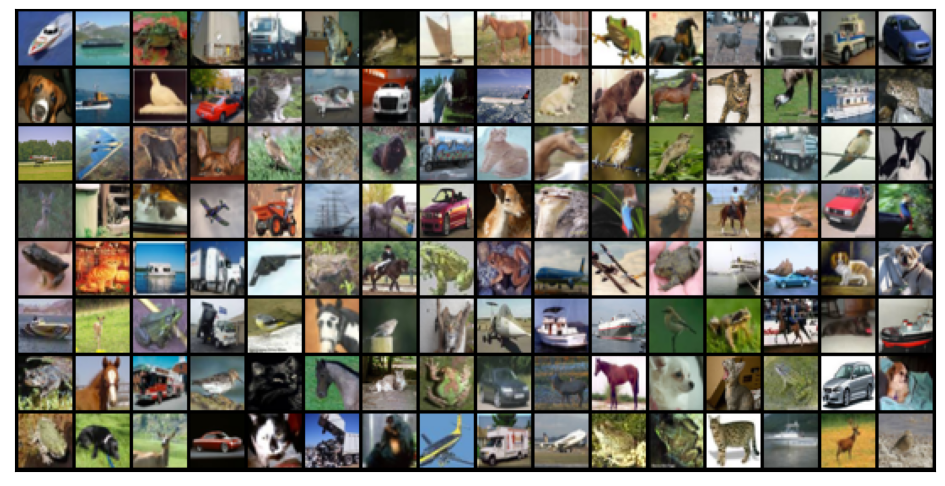

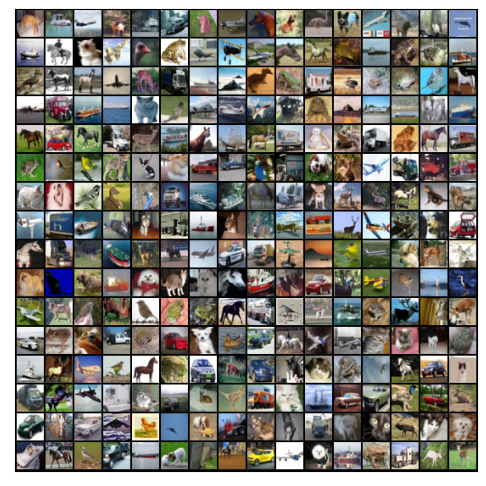

In [34]:
#split the dataset
torch.manual_seed(random_seed);
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

#load train and val set
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

#visualize a batch of train and val set
if viewDatasetExample:
    show_batch(train_dl)
    show_batch(val_dl)

#set device and deviceDL
device = get_default_device()
print("Using",device)

#Available Models:
#1) LegacyNet
#2) LegacyNetNorm
#3) SmallNet
#4) LeNet5

model = to_device(LegacyNetNorm(10, batch_size), device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

weightsFileName = model.__class__.__name__ + '_' + str(num_epochs) + 'Epochs' + '.pth'

if skipTraining == 0:
    history, epochTimes = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
    torch.save(model.state_dict(), weightsFileName)
else:
    if os.path.isfile(weightsFileName):
        model.load_state_dict(torch.load(weightsFileName))
        print("weights loaded successfully")
    else:
        print("previous weight configuration savefile not found for this particular configuration, the net is untrained")

In [ ]:
#plot_accuracies(history)

In [ ]:
#plot_losses(history)

In [ ]:
#Load Test Dataset
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)

result = evaluate(model, test_loader)
result

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Parameters in the net:", pytorch_total_params)

In [ ]:
#os.listdir('./data/101_ObjectCategories/bass')
#os.listdir('./data/cifar10')

count = 0
for root_dir, cur_dir, files in os.walk(r'./data/101_ObjectCategories'):
    count += len(files)
print('file count:', count)

In [ ]:
os.chdir(r'/kaggle/working')

from IPython.display import FileLink

FileLink(r'LeNet5_10Epochs.pth')